In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib import colors as mcolors
import math
import numpy as np
import matplotlib.pyplot as plt  # for plotting stuff
from random import seed
from scipy.stats import multivariate_normal  # generating synthetic data
from collections import namedtuple
from DROFairModels import DROFairModels
from collections import defaultdict
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from Linear_Ferm_SVM1 import Linear_FERM
# from fair_logloss import EOPP_fair_logloss_classifier
import pandas as pd
import os
from random import shuffle
import warnings
warnings.filterwarnings('ignore')

In [3]:
current_path=os.getcwd()
current_path

'/Users/wangyijiemacbook/Desktop/codes/fairness/Wasserstein_Robust_Classification_with_Fairness_Constraints'

In [4]:
SEED = 1
seed(SEED)
np.random.seed(SEED)
rng = np.random.RandomState(SEED)
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

h = .02  # step size in the mesh

In [5]:
def get_marginals(sensitives, target):
    """Calculate marginal probabilities of test data"""
    N_test = sensitives.shape[0]
    P_11 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_01 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == 1 else 0 for i
         in range(N_test)])
    P_10 = np.sum(
        [1 / N_test if sensitives[i] == 1 and target[i] == -1 else 0 for i
         in range(N_test)])
    P_00 = np.sum(
        [1 / N_test if sensitives[i] == 0 and target[i] == -1 else 0 for i
         in range(N_test)])
    if np.abs(P_01 + P_10 + P_11 + P_00 - 1) > 1e-10:
        print(np.abs(P_01 + P_10 + P_11 + P_00 - 1))
        print('Marginals are WRONG!')
    return P_11, P_01, P_10, P_00

def stratified_sampling(X, a, y, emp_marginals, n_train_samples):
    emp_P_11 = emp_marginals[0]
    emp_P_01 = emp_marginals[1]
    emp_P_10 = emp_marginals[2]
    emp_P_00 = emp_marginals[3]
    X_11, X_01, X_10, X_00 = [], [], [], []
    for i in range(X.shape[0]):
        if a[i] == 1 and y[i] == 1:
            X_11.append(X[i, :])
        if a[i] == 0 and y[i] == 1:
            X_01.append(X[i, :])
        if a[i] == 1 and y[i] == -1:
            X_10.append(X[i, :])
        if a[i] == 0 and y[i] == -1:
            X_00.append(X[i, :])
    ind_11 = np.random.randint(low=0, high=np.array(X_11).shape[0], size=int(emp_P_11 * n_train_samples))
    ind_01 = np.random.randint(low=0, high=np.array(X_01).shape[0], size=int(emp_P_01 * n_train_samples))
    ind_10 = np.random.randint(low=0, high=np.array(X_10).shape[0], size=int(emp_P_10 * n_train_samples))
    ind_00 = np.random.randint(low=0, high=np.array(X_00).shape[0], size=int(emp_P_00 * n_train_samples))
    X_train_11 = np.array(X_11)[ind_11, :]
    X_train_01 = np.array(X_01)[ind_01, :]
    X_train_10 = np.array(X_10)[ind_10, :]
    X_train_00 = np.array(X_00)[ind_00, :]
    X_test11 = np.delete(np.array(X_11), ind_11, axis=0)
    X_test01 = np.delete(np.array(X_01), ind_01, axis=0)
    X_test10 = np.delete(np.array(X_10), ind_10, axis=0)
    X_test00 = np.delete(np.array(X_00), ind_00, axis=0)
    test_sensitives = np.hstack([[1] * X_test11.shape[0], [0] * X_test01.shape[0],
                                 [1] * X_test10.shape[0], [0] * X_test00.shape[0]])
    y_test = np.hstack([[1] * X_test11.shape[0], [1] * X_test01.shape[0],
                        [0] * X_test10.shape[0], [0] * X_test00.shape[0]])
    X_test = np.vstack([X_test11, X_test01, X_test10, X_test00])
    y_train = np.hstack([[1] * int(emp_P_11 * n_train_samples), [1] * int(emp_P_01 * n_train_samples),
                         [0] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    train_sensitives = np.hstack([[1] * int(emp_P_11 * n_train_samples), [0] * int(emp_P_01 * n_train_samples),
                                  [1] * int(emp_P_10 * n_train_samples), [0] * int(emp_P_00 * n_train_samples)])
    X_train = np.vstack([X_train_11, X_train_01, X_train_10, X_train_00])

    threshold = 1 - sum(y == 1) / y.shape[0]
    return X_train, train_sensitives, y_train, X_test, test_sensitives, y_test, threshold



In [6]:
# X,y,a=load_drug_data()
# X,y,a=load_compas_data()
# y[y==0] = -1

from toolbox import *
# Parameter GRID
rho = 0.01
n_train_samples = 50
# etas = np.linspace(start=0, stop=0.1, num=5)
etas = np.linspace(start=0.05, stop=0.25, num=5)
# etas2 = np.linspace(start=0.6, stop=0.8, num=5)
etas2 = np.linspace(start=1.2, stop=1.6, num=5)
C=np.logspace(start=-1,stop=1,num=3)
# etas=np.array([0,10,100,1000,10000,100000])

fsvm_curves_train=np.zeros([etas.shape[0], 2]) # the first column will be unfairness and the second column will be accuracy
fsvm_curves_test=np.zeros([etas.shape[0], 2])
fprob_curves_train=np.zeros([etas.shape[0], 2]) 
fprob_curves_test=np.zeros([etas.shape[0], 2])
drfsvm_curves_train=np.zeros([etas.shape[0], 2]) 
drfsvm_curves_test=np.zeros([etas.shape[0], 2])
drfprob_curves_train=np.zeros([etas.shape[0], 2]) 
drfprob_curves_test=np.zeros([etas.shape[0], 2])
dob_curves=np.zeros([1,2])
logloss_curves_train=np.zeros([etas.shape[0], 2])
logloss_curves_test=np.zeros([etas.shape[0], 2])



k3=0
while k3 < 50:
    
    X,y,a=load_compas_data()
    y[y==0] = -1
    true_P_11, true_P_01, true_P_10, true_P_00 = get_marginals(a, y)
    emp_marginals = [true_P_11, true_P_01, true_P_10, true_P_00]



    X_train, a_train, y_train, X_test, a_test, y_test, threshold = stratified_sampling(
        X=X,
        a=a,
        y=y, emp_marginals=emp_marginals,
        n_train_samples=n_train_samples)
    
    y_train[y_train==0] = -1
    y_test[y_test==0] = -1
    train_P_11, train_P_01, _, _ = get_marginals(a_train, y_train)
    etas3 = np.linspace(start=0.05, stop=min(train_P_11,train_P_01)-0.001, num=5)
    
    

    y_train[y_train==0] = -1
    y_test[y_test==0] = -1
    

    
    eta = 1
    fprob=DROFairModels(reg=eta, radius=0, epsilon=0.01,
                                      verbose=False, fit_intercept=True)
    fprob.fit(X=X_train, a=a_train, y=y_train)
    abs_unf = fprob.unfairness(X_train,a_train,y_train).eo_unfairness
    # unf = fprob.unfairness2(X_test,X_test,X_test).eo_unfairness
    if abs_unf<0:
        a_train = 1 - a_train
        
    if np.abs(abs_unf) < 0.25:
        continue
    
    print('number of iteration: ', k3)
        
    for i, eta in enumerate(etas):
        
        fprob = DROFairModels(reg=eta, radius=0, epsilon=0.01,
                                        verbose=False, fit_intercept=True, mode = 'DRFPROB',sreg=True)
        fprob.fit(X=X_train, a=a_train, y=y_train)
        drfprob= DROFairModels(reg=eta, radius=0.05, epsilon=0.01,
                                        verbose=False, fit_intercept=True, mode = 'DRFPROB',sreg=True)
        drfprob.fit(X=X_train, a=a_train, y=y_train)
        
        fprob_curves_test[i,0]=fprob.unfairness(X_test,a_test,y_test).det_unfairness+fprob_curves_test[i,0]
        fprob_curves_test[i,1]=fprob.score(X_test,y_test)+fprob_curves_test[i,1]
        drfprob_curves_test[i,0]=drfprob.unfairness(X_test,a_test,y_test).det_unfairness+drfprob_curves_test[i,0]
        drfprob_curves_test[i,1]=drfprob.score(X_test,y_test)+drfprob_curves_test[i,1]
        
    
    for i, eta in enumerate(etas2):
    #     implement models
        fsvm=DROFairModels(reg=eta, radius=0, epsilon=0.01,
                                        verbose=False, fit_intercept=True, mode = 'DRFSVM')
        fsvm.fit(X=X_train, a=a_train, y=y_train)
        drfsvm=DROFairModels(reg=eta, radius=0.05, epsilon=0.01,
                                    verbose=False, fit_intercept=True, mode = 'DRFSVM')
        drfsvm.fit(X=X_train, a=a_train, y=y_train)

        fsvm_curves_test[i,0]=fsvm.unfairness(X_test,a_test,y_test).det_unfairness+fsvm_curves_test[i,0]
        fsvm_curves_test[i,1]=fsvm.score(X_test,y_test)+fsvm_curves_test[i,1]
        drfsvm_curves_test[i,0]=drfsvm.unfairness(X_test,a_test,y_test).det_unfairness+drfsvm_curves_test[i,0]
        drfsvm_curves_test[i,1]=drfsvm.score(X_test,y_test)+drfsvm_curves_test[i,1]
    

    param_grid = [{'C': [0.1, 1.0,10], 'kernel': ['linear']}]
    # param_grid = [{'C': [1.0], 'kernel': ['linear']}]
    svc = svm.SVC()
    clf_ferm = GridSearchCV(svc, param_grid, n_jobs=1)
    ferm = Linear_FERM(data=X_train, target=y_train, model=clf_ferm, sensible_feature=a_train)
    ferm.fit()
    dob_curves[0,0]+=ferm.unfairness(X_test,a_test,y_test).det_unfairness
    dob_curves[0,1]+=ferm.score(X_test,y_test)
    
    
    for i, eta in enumerate(etas3):
        # FAIR LOGISTIC REGRESSION
        # print(eta)
        y_train[y_train==-1]=0
        y_test[y_test==-1]=0
        fclf_emp = DROFairModels(reg=eta, radius=0.005, epsilon=0.01,
                                        verbose=False, fit_intercept=True, mode = 'DRFLR')
        fclf_emp.fit(X=X_train, a=a_train, y=y_train)
        UNF_emp = fclf_emp.unfairness(X=X_test, a=a_test, y=y_test)
        score_emp = fclf_emp.score(X_test, y_test)
        logloss_curves_test[i,0]+=fclf_emp.unfairness(X_test,a_test,y_test).det_unfairness
        logloss_curves_test[i,1]+=fclf_emp.score(X_test,y_test)
        
    k3 +=1
        
fsvm_curves_test[:,0]=fsvm_curves_test[:,0]/k3
fsvm_curves_test[:,1]=fsvm_curves_test[:,1]/k3
drfsvm_curves_test[:,0]=drfsvm_curves_test[:,0]/k3
drfsvm_curves_test[:,1]=drfsvm_curves_test[:,1]/k3
fprob_curves_test[:,0]=fprob_curves_test[:,0]/k3
fprob_curves_test[:,1]=fprob_curves_test[:,1]/k3
drfprob_curves_test[:,0]=drfprob_curves_test[:,0]/k3
drfprob_curves_test[:,1]=drfprob_curves_test[:,1]/k3
dob_curves[:,0]=dob_curves[:,0]/k3
dob_curves[:,1]=dob_curves[:,1]/k3
logloss_curves_test[:,0]=logloss_curves_test[:,0]/k3
logloss_curves_test[:,1]=logloss_curves_test[:,1]/k3



Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-24
number of iteration:  0
number of iteration:  1
number of iteration:  2
number of iteration:  3
number of iteration:  4
number of iteration:  5
number of iteration:  6
number of iteration:  7
number of iteration:  8
number of iteration:  9
number of iteration:  10
number of iteration:  11
number of iteration:  12
number of iteration:  13
number of iteration:  14
number of iteration:  15
number of iteration:  16
number of iteration:  17
number of iteration:  18
number of iteration:  19
number of iteration:  20
number of iteration:  21
number of iteration:  22
number of iteration:  23
number of iteration:  24
number of iteration:  25
number of iteration:  26
number of iteration:  27
number of iteration:  28
number of iteration:  29
number of iteration:  30
number of iteration:  31
number of iteration:  32
number of iteration:  33
number of iteration:  34
number of iteration:  35
number of iteration

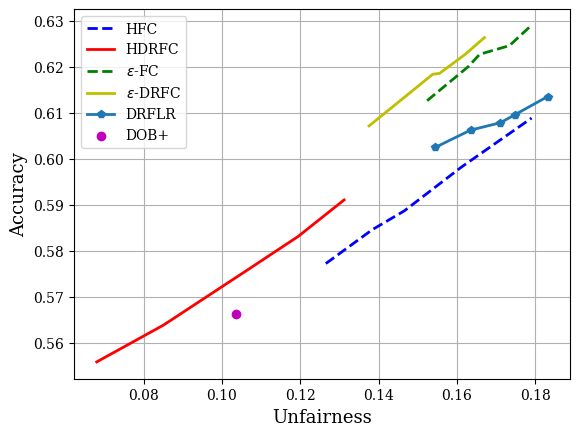

In [7]:
plt.close('all')
plt.figure()
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

ax = plt.subplot(111)
plt.plot(fsvm_curves_test[:, 0], fsvm_curves_test[:, 1], 'b--', label='HFC', lw=2)
plt.plot(drfsvm_curves_test[:, 0], drfsvm_curves_test[:, 1],'r-', label='HDRFC', lw=2)
plt.plot(fprob_curves_test[:, 0], fprob_curves_test[:, 1], 'g--', label='$\epsilon$-FC', lw=2)
plt.plot(drfprob_curves_test[:, 0], drfprob_curves_test[:, 1],'y-', label='$\epsilon$-DRFC', lw=2)
plt.plot(logloss_curves_test[:, 0], logloss_curves_test[:, 1],'p-', label='DRFLR', lw=2)
plt.scatter(dob_curves[0, 0], dob_curves[0, 1],c='m', label='DOB+')
# plt.plot(dob_curves[:, 0], dob_curves[:, 1],'g-', label='DRFSVM', lw=2)
plt.xlabel('Unfairness', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
# plt.title('Frontiers', fontsize=13)
# plt.xlim(0,1)
# plt.ylim(0.83,0.89)
plt.grid()
plt.legend(fontsize=10)
plt.show()